# part0: imports

In [1]:
import os, sys, pathlib
from pprint import pprint
import gc
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)

import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg
from scipy.stats import pearsonr

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import MaxNLocator
from matplotlib.collections import LineCollection
%matplotlib inline
%config InlineBackend.figure_formats = ['png2x']


import pyaldata as pyal
import defs

try:
    nbPath = pathlib.Path.cwd()
    RepoPath = nbPath.parent
    os.chdir(RepoPath)

    from tools import utilityTools as utility
    from tools import dataTools as dt
    import params
    set_rc =  params.set_rc_params
    set_rc()
    root = params.root

finally:
    os.chdir(nbPath)


%run "_dataset-selection.ipynb"

the variable `GoodDataList` contains the session names




load the data

In [2]:
full_list_M1 = []
for animal, sessionList in GoodDataList[areas[0]].items():
    if 'Mr' in animal:
        continue  # to remove MrT
    full_list_M1.append((animal,sessionList))
full_list_M1 = [(animal,session) for animal,sessions in full_list_M1 for session in set(sessions)]
# load the DFs
warnings.filterwarnings("ignore")
allDFs_M1 = []
for animal, session in full_list_M1:
    path = root/animal/session
    allDFs_M1.append(prep_general(dt.load_pyal_data(path)))


full_list_PMd = []
for animal, sessionList in GoodDataList[areas[1]].items():
    if 'Mr' in animal:
        continue  # to remove MrT
    full_list_PMd.append((animal,sessionList))
full_list_PMd = [(animal,session) for animal,sessions in full_list_PMd for session in set(sessions)]
# load the DFs
allDFs_PMd = []
for animal, session in full_list_PMd:
    path = root/animal/session
    allDFs_PMd.append(prep_general(dt.load_pyal_data(path)))
warnings.filterwarnings("default")

df = allDFs_M1[0]

# check the duration

In [10]:
def reach_phase_len(df):
    keys = np.unique(df.target_id)
    out = {key:[] for key in keys}
    for i, traj in enumerate(df.vel):
        a = traj[int(df.idx_movement_on[i]):int(df.idx_trial_end[i]),0]
        cleanTraj = a[np.logical_not(np.isnan(a))]
        out[df.target_id[i]].append(len(cleanTraj) * df.bin_size[i])

    return out

Text(0.09, 0.5, 'Different datasets')

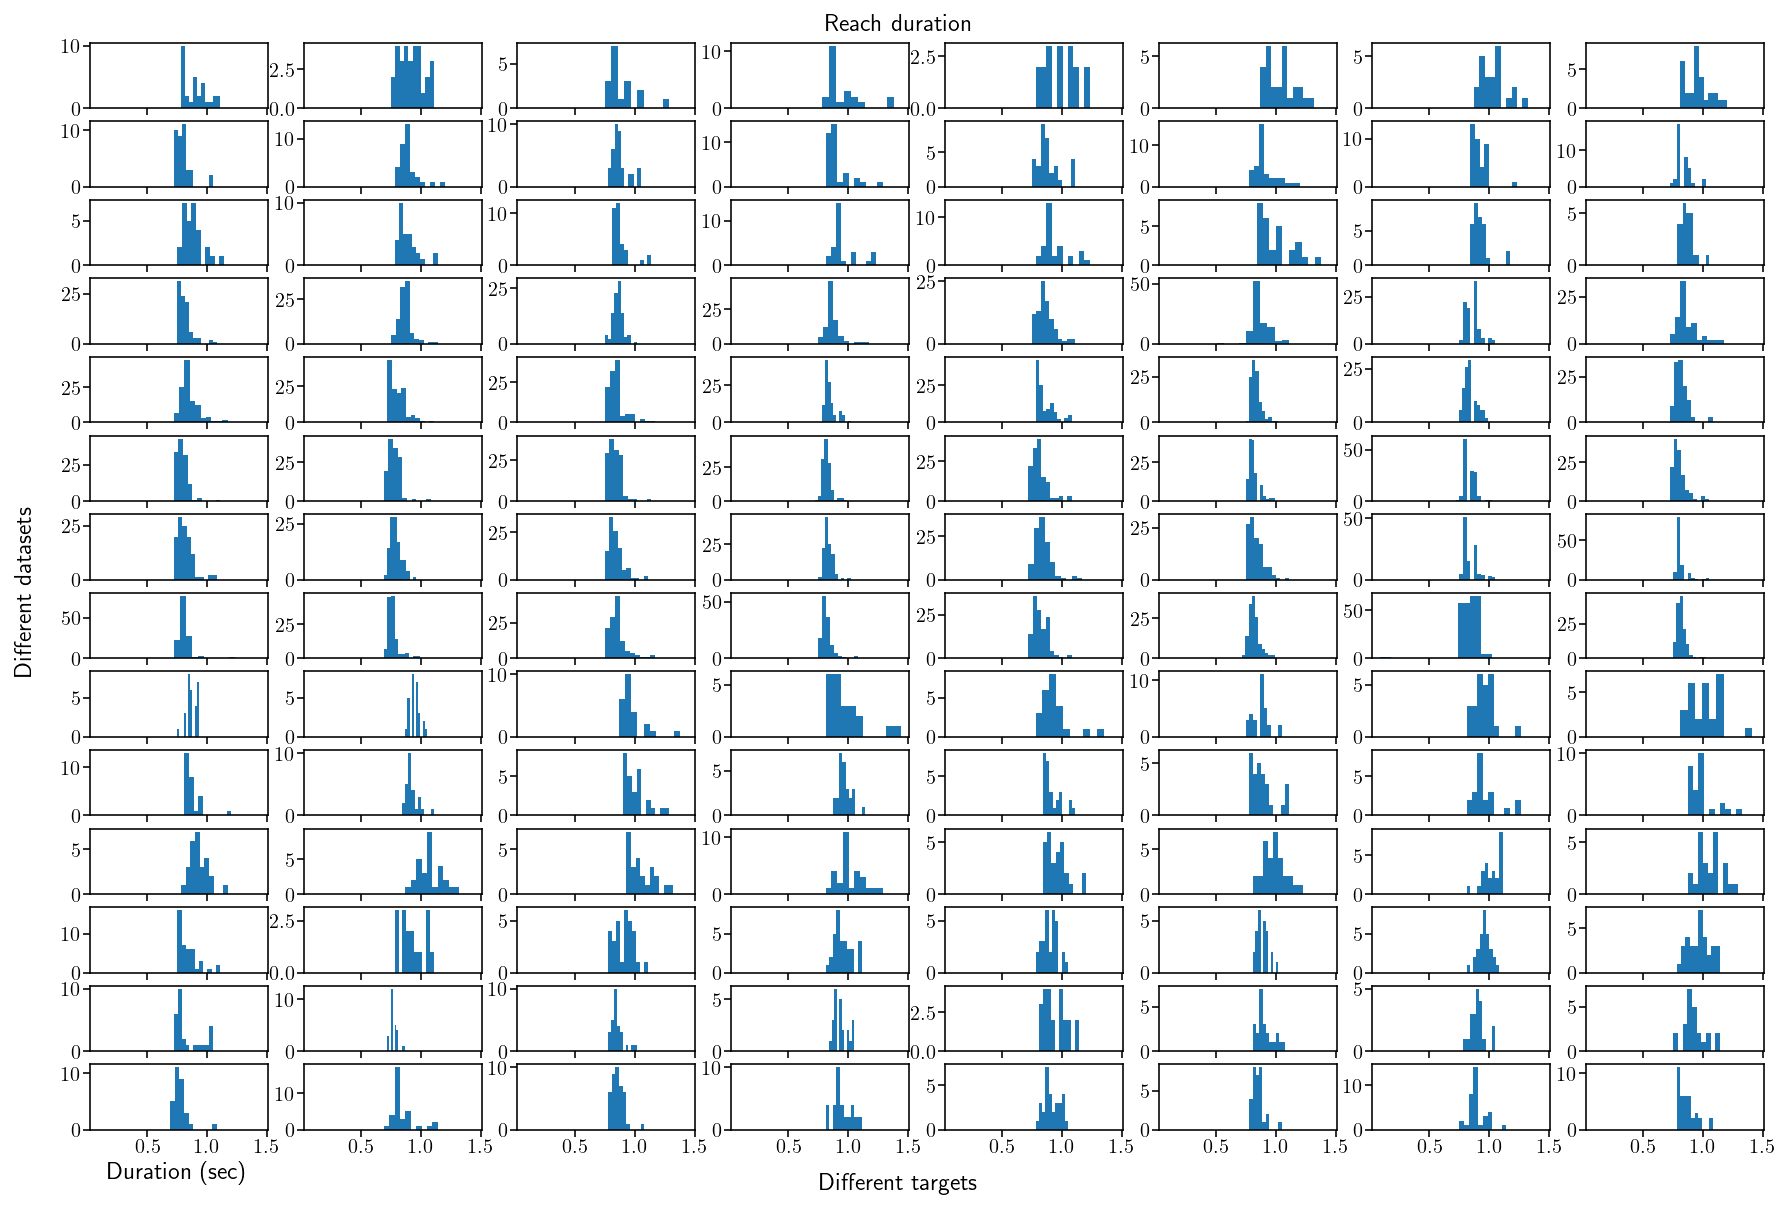

In [11]:
fig,axes = plt.subplots(len(allDFs_M1),len(np.unique(df.target_id)),figsize=(15,10), sharex=True)


for row,df in enumerate(allDFs_M1):
    a = reach_phase_len(df)
    for col, data in a.items():
        axes[row,col].hist(np.array(data))
fig.suptitle('Reach duration', y=0.9);
axes[-1,0].set_xlabel('Duration (sec)')
fig.supxlabel('Different targets', y=.08)
fig.supylabel('Different datasets', x=.09)

## Correlate within and across sessions

target matched!!

In [29]:
for df in allDFs_PMd:
    df['session'] = df.monkey[0]+df.date[0]
                
within_corrs = {}
for df in allDFs_PMd:
    within_corrs[df.session[0]] = []
    targets = np.unique(df.target_id)
    for target in targets:
        df_ = pyal.select_trials(df, df.target_id == target)
        for i, vel1 in enumerate(df_.vel):
            a = vel1[int(df_.idx_movement_on[i]):int(df_.idx_trial_end[i]),:]
            for j, vel2 in enumerate(df_.vel):
                if j<=i: continue
                b = vel2[int(df_.idx_movement_on[j]):int(df_.idx_trial_end[j]),:]
                a_,b_ = dt.warp_time(a,b)
                r = [pearsonr(aa,bb)[0] for aa,bb in zip(a_.T,b_.T)]
                within_corrs[df_.session[0]].append(np.median(np.abs(r)))


across_corrs = {}
for dfi, df1 in enumerate(allDFs_PMd):
    targets = np.unique(df1.target_id)
    across_corrs[df1.session[0]]={}
    for dfj, df2 in enumerate(allDFs_PMd):
        if dfj <= dfi: continue
        across_corrs[df1.session[0]][df2.session[0]]=[]
        for target in targets:
            df1_ = pyal.select_trials(df1, df1.target_id == target)
            df2_ = pyal.select_trials(df2, df2.target_id == target)
            for i, vel1 in enumerate(df1_.vel):
                a = vel1[int(df1_.idx_movement_on[i]):int(df1_.idx_trial_end[i]),:]
                for j, vel2 in enumerate(df2_.vel):
                    b = vel2[int(df2_.idx_movement_on[j]):int(df2_.idx_trial_end[j]),:]
                    a_,b_ = dt.warp_time(a,b)
                    r = [pearsonr(aa,bb)[0] for aa,bb in zip(a_.T,b_.T)]
                    across_corrs[df1_.session[0]][df2_.session[0]].append(np.median(np.abs(r)))


Text(0.92, 0.5, 'Different sessions')

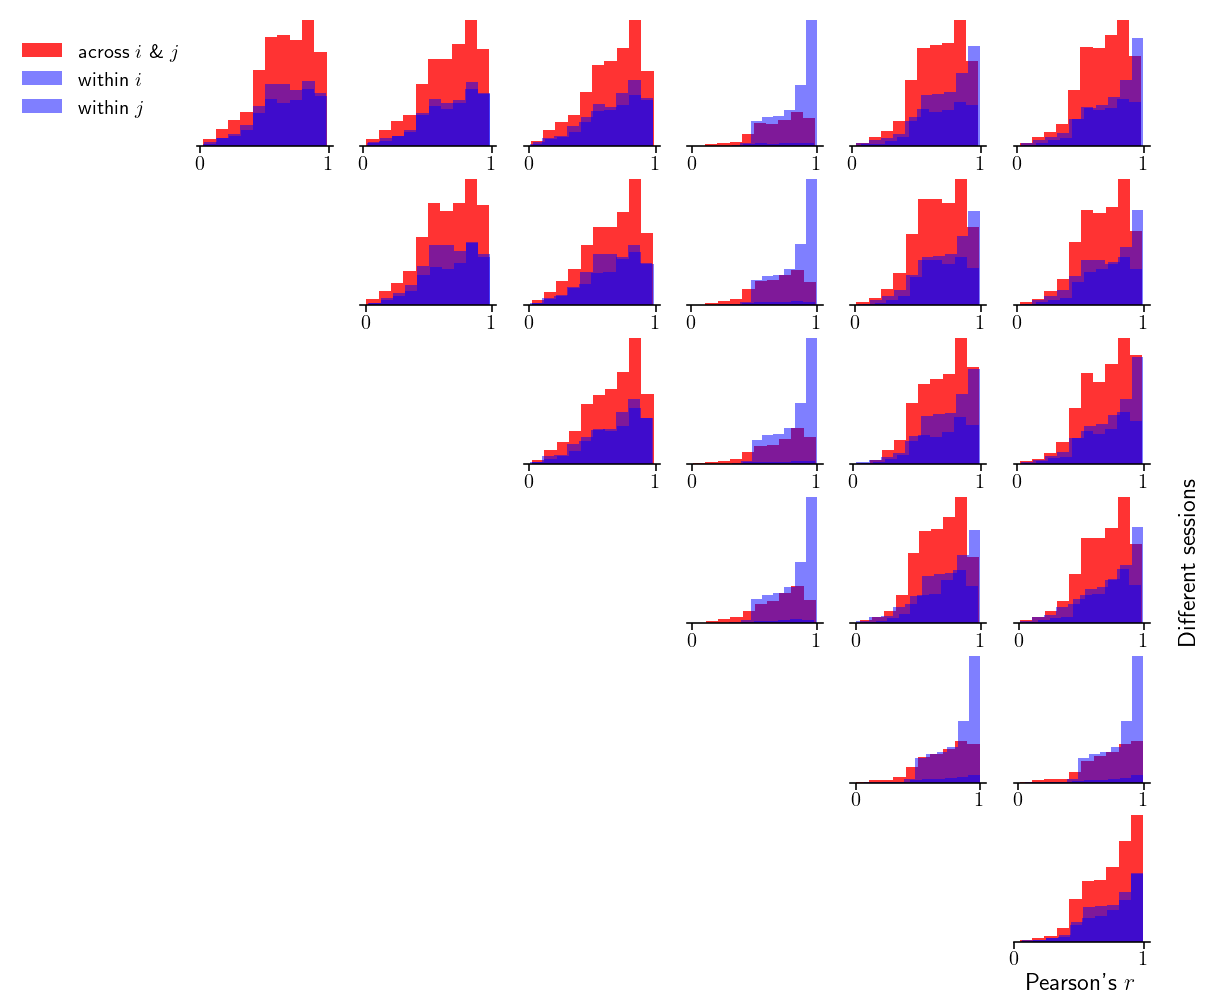

In [33]:
fig,axes = plt.subplots(len(allDFs_PMd),len(allDFs_PMd),figsize=(10,10),)

for i, df1 in enumerate(allDFs_PMd):
    for j, df2 in enumerate(allDFs_PMd):
        if j<=i:
            utility.phantom_axes(axes[i,j])
            continue
        ax = axes[i,j]
        ax.hist(across_corrs[df1.session[0]][df2.session[0]],alpha=.8,color='r',label=r'across $i$ \& $j$')
        ax.hist(within_corrs[df1.session[0]],alpha=.5,color='b',label='within $i$')
        ax.hist(within_corrs[df2.session[0]],alpha=.5,color='b',label='within $j$')
        ax.set_yticks([])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)

[fig.delaxes(ax) for ax in axes[-1,:]]
axes[0,1].legend(bbox_to_anchor=(0,.5),loc=7)
axes[-2,-1].set_xlabel(r"Pearson's $r$")
fig.supylabel('Different sessions', x=.92)


### no warping

trimming instead: not expected much difference as the behaviour is largely consistent, so the durations are similar

In [ ]:
def time_trim(a,b):
    l = min(a.shape[0],b.shape[0])
    return a[:l],b[:l]


for df in allDFs_PMd:
    if 'session' in df.columns:continue
    df['session'] = df.monkey[0]+df.date[0]

trim_within_corrs = {}
for df in allDFs_PMd:
    trim_within_corrs[df.session[0]] = []
    targets = np.unique(df.target_id)
    for target in targets:
        df_ = pyal.select_trials(df, df.target_id == target)
        for i, vel1 in enumerate(df_.vel):
            a = vel1[int(df_.idx_movement_on[i]):int(df_.idx_trial_end[i]),:]
            for j, vel2 in enumerate(df_.vel):
                if j<=i: continue
                b = vel2[int(df_.idx_movement_on[j]):int(df_.idx_trial_end[j]),:]
                if abs(len(b) - len(a)) > 3 * min((len(b) , len(a))):
                    logging.warning(f'mismatching trial pair dropeed: {len(a)=},{len(b)=}')
                    continue
                a_,b_ = time_trim(a,b)
                r = [pearsonr(aa,bb)[0] for aa,bb in zip(a_.T,b_.T)]
                trim_within_corrs[df_.session[0]].append(np.mean(np.abs(r)))


trim_across_corrs = {}
for dfi, df1 in enumerate(allDFs_PMd):
    targets = np.unique(df1.target_id)
    trim_across_corrs[df1.session[0]]={}
    for dfj, df2 in enumerate(allDFs_PMd):
        if dfj <= dfi: continue
        trim_across_corrs[df1.session[0]][df2.session[0]]=[]
        for target in targets:
            df1_ = pyal.select_trials(df1, df1.target_id == target)
            df2_ = pyal.select_trials(df2, df2.target_id == target)
            for i, vel1 in enumerate(df1_.vel):
                a = vel1[int(df1_.idx_movement_on[i]):int(df1_.idx_trial_end[i]),:]
                for j, vel2 in enumerate(df2_.vel):
                    b = vel2[int(df2_.idx_movement_on[j]):int(df2_.idx_trial_end[j]),:]
                    if abs(len(b) - len(a)) > 3 * min((len(b) , len(a))):
                        logging.warning(f'mismatching trial pair dropeed: {len(a)=},{len(b)=}')
                        continue
                    a_,b_ = time_trim(a,b)
                    r = [pearsonr(aa,bb)[0] for aa,bb in zip(a_.T,b_.T)]
                    trim_across_corrs[df1_.session[0]][df2_.session[0]].append(np.mean(np.abs(r)))


Text(0.92, 0.5, 'Different sessions')

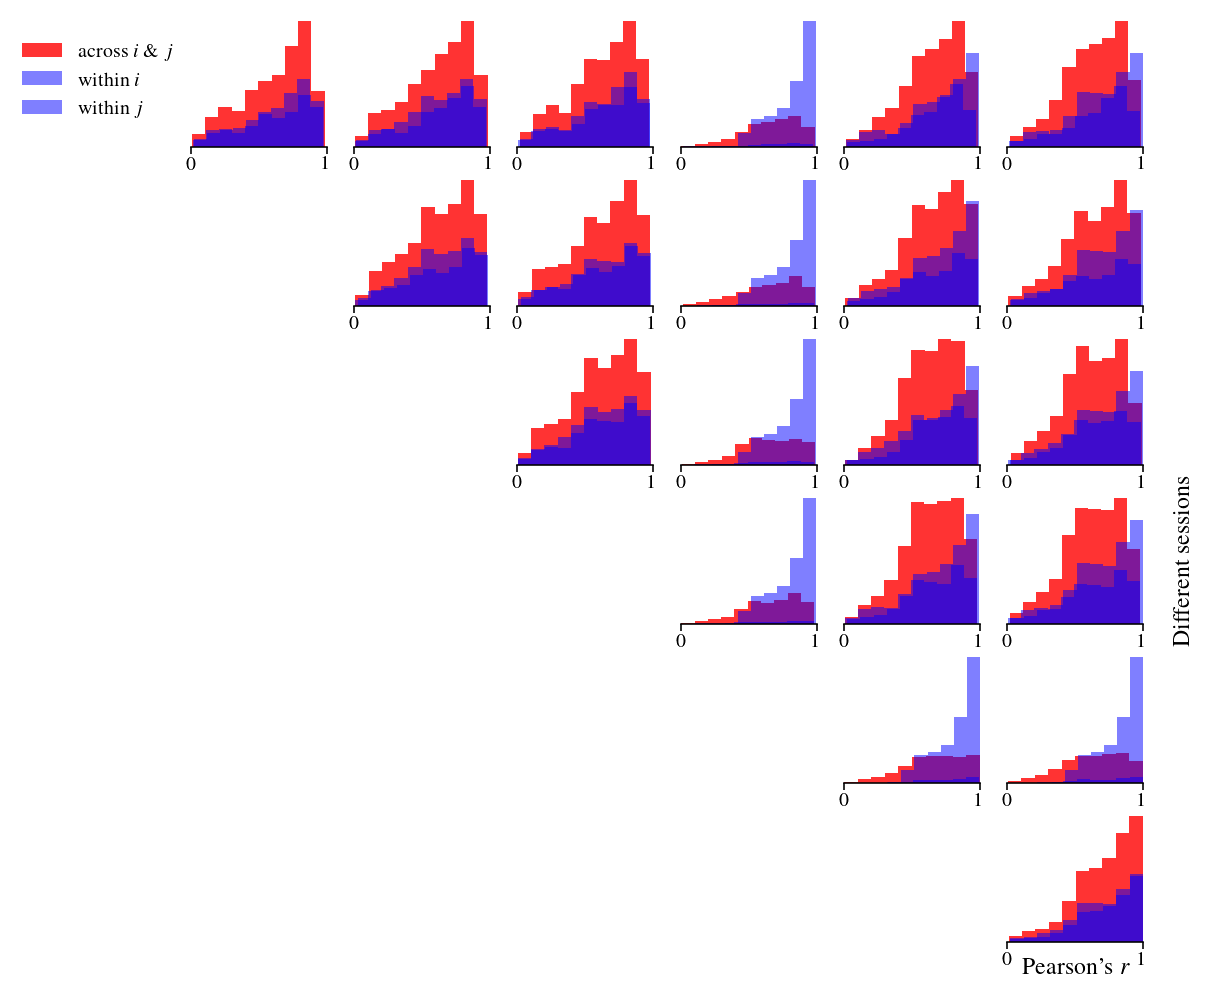

In [11]:
fig,axes = plt.subplots(len(allDFs_PMd),len(allDFs_PMd),figsize=(10,10))

for i, df1 in enumerate(allDFs_PMd):
    for j, df2 in enumerate(allDFs_PMd):
        if j<=i:
            utility.phantom_axes(axes[i,j])
            continue
        ax = axes[i,j]
        ax.hist(trim_across_corrs[df1.session[0]][df2.session[0]],alpha=.8,color='r',label=r'across $i$ \& $j$')
        ax.hist(trim_within_corrs[df1.session[0]],alpha=.5,color='b',label='within $i$')
        ax.hist(trim_within_corrs[df2.session[0]],alpha=.5,color='b',label='within $j$')
        ax.set_yticks([])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.set_xlim([0,1])
        ax.set_xticks([0,1])

[fig.delaxes(ax) for ax in axes[-1,:]]
axes[0,1].legend(bbox_to_anchor=(0,.5),loc=7)
axes[-2,-1].set_xlabel(r"Pearson's $r$", labelpad=-6);
fig.supylabel('Different sessions', x=.92)
